# Laboratorio 6

Por: Amalia Carbonell & Santiago Casasbuenas

## Problema 1: Corridor crawler (Laberinto Determinístico)

### 1. Diseño de la Representación

Estamos utilizando una representación basada en un conjunto de reglas para la navegación del robot, específicamente una "Tabla de decisiones o máquina de estados simple".

En esta implementación, cada individuo en la población tiene una tabla que mapea estados a acciones. Cada estado está codificado por:

1. La configuración de paredes alrededor del robot (4 bits, uno por cada dirección - Norte, Este, Sur, Oeste)
2. El último movimiento realizado (4 bits adicionales)

Esto crea un total de 256 posibles estados (2^8), y para cada estado, el robot tiene cuatro posibles acciones (moverse al Norte, Este, Sur u Oeste).
Esta representación es más efectiva que una secuencia directa de movimientos porque:

1. Es compacta (solo 256 reglas vs cientos de pasos secuenciales)
2. Permite generalizar patrones en el laberinto en lugar de solo memorizar un camino específico
3. Puede adaptarse a diferentes situaciones según el entorno inmediato

La tabla de decisiones permite que el robot tome decisiones locales basadas en su entorno inmediato y su movimiento anterior, lo que le da cierto "contexto" para evitar ciclos y seguir estrategias como el seguimiento de paredes.

### 2. Implementación del Algoritmo Genético

#### Función de Aptitud (Fitness Function)
La función premiará la eficiencia del robot, castigando comportamientos que no aporten al desarrollo de la eficiencia.

**Bonificación por alcanzar la salida (bonificacion_salida):**\
Valor muy alto (10000 puntos) si el robot llega a la salida. Esto hace que cualquier solución que encuentre la salida sea enormemente preferida.

**Bonificación por eficiencia (bonificacion_pasos):**\
Recompensa soluciones que llegan a la salida en menos pasos, se calcula como max(0, 3 * (pasos_maximos - pasos)) y se da mayor bonificación cuanto menor sea el número de pasos utilizados.

**Penalización por distancia (penalizacion_distancia):**\
Penaliza según la distancia mínima alcanzada a la salida y utiliza la distancia Manhattan (suma de diferencias absolutas en x e y). Luego, se multiplica por un factor alto (100) para dar importancia a acercarse a la meta y utilizamos la distancia mínima alcanzada durante toda la ejecución, no solo la final.

**Penalización por colisiones (penalizacion_colision):**\
Penaliza cada vez que el robot intenta moverse hacia una pared. Cada colisión reduce la aptitud en 2 puntos, fomentando soluciones que evitan chocar con obstáculos.

**Penalización por oscilación (penalizacion_progreso):**\
Penaliza comportamientos repetitivos como ciclos cortos o revisitar frecuentemente las mismas celdas, esto sucede cuando una posición es visitada más de 4 veces (10 puntos de penalización). También penaliza ciclos de 3 pasos (5 puntos de penalización). Los bucles tmb se penalizan.

**Bonificación por exploración (bonificacion_exploracion):**\
Recompensa al robot por explorar más celdas únicas del laberinto (10 puntos por cada celda única visitada) y se fomenta la diversidad de rutas y evita que el robot se quede en áreas pequeñas.

#### Operadores Genéricos

**Selección (seleccionar_padres):** Implementamos un método de selección por torneo con un tamaño de torneo de 5 individuos. Esto generó mayor presión selectiva ya que el tamaño relativamente grande del torneo (5 competidores) crea una presión selectiva más fuerte, favoreciendo significativamente a los individuos más aptos. Tmb se genera un balance entre exploración y explotación, lo que mantiene cierta diversidad en la población (cualquier individuo tiene oportunidad de ser seleccionado) mientras favorece a los mejores individuos. Usamos la selección de torneo porque es eficiente a nivel computacional.

**Cruce (cruzar):** Utilizamos cruce uniforme en lugar de cruce de un punto o dos puntos. El cruce uniforme permite una mezcla más equilibrada de las estrategias de ambos padres, ya que cada gen (acción para un estado específico) tiene una probabilidad del 50% de venir de cada padre. Además, este permite mantener intactas subestructuras útiles (conjuntos de reglas que funcionan bien juntas). La taza de cruce que se mantiene es del 80%, con el fin de fomentar la exploración del laberinto.

**Mutación (mutar):** La mutación no es puramente aleatoria ya que se considera la configuración de paredes en cada estado. Para cada estado, la mutación intenta seleccionar movimientos que no resulten en colisiones con paredes. La tasa de mutación aumenta automáticamente (hasta un máximo de 0.4) cuando se detecta convergencia. La tasa inicial de mutación (0.2) permite suficiente exploración sin destruir posibles soluciones. Este método nos permite escapar facilmente de óptimos locales que pueden estancar el proceso de llegar a una solución verdadera.

**Elitismo:** Mantenemos un pequeño número de los mejores individuos (hasta el 2% de la población) sin alteraciones en cada generación. Esto asegura que no perdemos las mejores soluciones encontradas hasta el momento.

#### Código

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import ListedColormap
import time

# Variables globales para direcciones
NORTE = 0
ESTE = 1
SUR = 2
OESTE = 3

# Definir posibles movimientos en coordenadas (x, y)
MOVIMIENTOS = {
    NORTE: (-1, 0),
    ESTE: (0, 1),
    SUR: (1, 0),
    OESTE: (0, -1)
}

Funciones para la carga de laberintos y obtención de posiciones

In [42]:
def cargar_laberinto(nombre_archivo):
    """Cargar laberinto desde archivo."""
    with open(nombre_archivo, 'r') as f:
        lineas = f.readlines()
    
    laberinto = []
    for linea in lineas:
        laberinto.append([int(celda) for celda in linea.strip().split()])
    
    return np.array(laberinto)

def obtener_posiciones_inicio_fin(laberinto):
    """Encontrar posiciones de inicio y fin en el laberinto."""
    # La posición de inicio está en la segunda fila (índice 1), celda abierta más a la izquierda
    # La posición final está en la penúltima fila, celda abierta más a la derecha
    
    # Encontrar posición de inicio (entrada del maze)
    for col in range(laberinto.shape[1]):
        if laberinto[1, col] == 0:
            pos_inicio = (1, col)
            break
    
    # Encontrar posición final (salida del maze)
    for col in range(laberinto.shape[1]-1, -1, -1):
        if laberinto[-2, col] == 0:
            pos_fin = (laberinto.shape[0]-2, col)
            break
    
    return pos_inicio, pos_fin

Definimos una clase para el algoritmo

In [43]:
class AlgoritmoGeneticoResolvedorLaberinto:
    def __init__(self, laberinto, pasos_maximos=1000, tamano_poblacion=300, generaciones=300,
                 tasa_mutacion=0.2, tasa_cruce=0.8, tamano_elite=4):
        self.laberinto = laberinto
        self.pasos_maximos = pasos_maximos
        self.tamano_poblacion = tamano_poblacion
        self.generaciones = generaciones
        self.tasa_mutacion = tasa_mutacion
        self.tasa_cruce = tasa_cruce
        self.tamano_elite = min(int(tamano_poblacion * 0.02), 8)  # Máximo 2% de la población
        
        # Encontrar posiciones de inicio y fin
        self.pos_inicio, self.pos_fin = obtener_posiciones_inicio_fin(laberinto)
        
        # Inicializar población
        self.poblacion = []
        self.mejor_aptitud = -float('inf')
        self.mejor_individuo = None
        self.mejor_camino = []
        
        # Codificación de estado extendida
        # Usaremos 4 bits para paredes + 4 bits para el último movimiento = 8 bits en total
        # Esto da 256 posibles estados (2^8)
        self.tamano_estado = 256
        self.acciones_por_estado = 4  # 4 posibles acciones por estado
        
        # Inicializar historial de aptitud para análisis de convergencia
        self.historial_aptitud = []
        
        # Precalcular distancia Manhattan desde cada posición hasta la salida
        self.mapa_distancia = self.crear_mapa_distancia()
    
    def crear_mapa_distancia(self):
        """Crear un mapa de distancias Manhattan desde cada posición abierta hasta la salida."""
        mapa_distancia = {}
        for i in range(self.laberinto.shape[0]):
            for j in range(self.laberinto.shape[1]):
                if self.laberinto[i, j] == 0:  # Camino abierto
                    mapa_distancia[(i, j)] = abs(i - self.pos_fin[0]) + abs(j - self.pos_fin[1])
        return mapa_distancia
    
    def detectar_estado(self, pos, ultimo_movimiento):
        """
        Devuelve una codificación de estado que incluye:
        - Paredes en las cuatro direcciones
        - El último movimiento realizado
        """
        # Primeros 4 bits: paredes en cada dirección (N, E, S, O)
        paredes = 0
        for i, (dx, dy) in enumerate(MOVIMIENTOS.values()):
            nx, ny = pos[0] + dx, pos[1] + dy
            # Comprobar si la siguiente posición es una pared o está fuera de límites
            if (nx < 0 or nx >= self.laberinto.shape[0] or 
                ny < 0 or ny >= self.laberinto.shape[1] or 
                self.laberinto[nx, ny] == 1):
                paredes |= (1 << i)  # Establecer el bit para esta dirección
        
        # Siguientes 4 bits: último movimiento (codificación one-hot)
        bits_movimiento = 0
        if ultimo_movimiento is not None:
            bits_movimiento = (1 << (4 + ultimo_movimiento))
        
        # Combinar información de paredes y movimiento en un solo estado
        estado = paredes | bits_movimiento
        
        return estado
    
    def inicializar_poblacion(self):
        """Inicializar población con estrategias aleatorias basadas en reglas."""
        self.poblacion = []
        
        # Crear individuos mayormente aleatorios
        for _ in range(self.tamano_poblacion - 10):
            # Para cada estado (configuración de paredes + último movimiento), 
            # asignar una acción aleatoria (N, E, S, O)
            individuo = np.random.randint(0, 4, size=self.tamano_estado)
            self.poblacion.append(individuo)
        
        # Crear algunos individuos con preferencia derecha/abajo
        for _ in range(5):
            individuo = np.zeros(self.tamano_estado, dtype=int)
            for i in range(self.tamano_estado):
                # Máscara de bits para paredes
                paredes = i & 0x0F
                
                # Si el este (derecha) no está bloqueado, ir al este con alta probabilidad
                if not (paredes & (1 << ESTE)):
                    if random.random() < 0.7:
                        individuo[i] = ESTE
                    else:
                        individuo[i] = random.choice([NORTE, SUR, OESTE])
                # Si el sur (abajo) no está bloqueado, ir al sur con alta probabilidad
                elif not (paredes & (1 << SUR)):
                    if random.random() < 0.7:
                        individuo[i] = SUR
                    else:
                        individuo[i] = random.choice([NORTE, ESTE, OESTE])
                # De lo contrario, elegir una dirección aleatoria no bloqueada
                else:
                    opciones = [d for d in [NORTE, ESTE, SUR, OESTE] if not (paredes & (1 << d))]
                    if opciones:
                        individuo[i] = random.choice(opciones)
                    else:
                        individuo[i] = random.randint(0, 3)
            self.poblacion.append(individuo)
        
        # Crear algunos individuos con heurística de seguimiento de pared
        for i in range(5):
            individuo = np.zeros(self.tamano_estado, dtype=int)
            preferencia = [ESTE, SUR, OESTE, NORTE]  # Regla de la mano derecha
            if i % 2 == 1:
                preferencia = [SUR, ESTE, NORTE, OESTE]  # Regla de la mano hacia abajo
            
            for j in range(self.tamano_estado):
                # Máscara de bits para paredes
                paredes = j & 0x0F
                
                # Probar direcciones en orden de preferencia
                for direccion in preferencia:
                    if not (paredes & (1 << direccion)):
                        individuo[j] = direccion
                        break
                else:
                    individuo[j] = random.randint(0, 3)
            
            self.poblacion.append(individuo)
    
    def evaluar_aptitud(self, individuo):
        """Evaluar la aptitud de un individuo."""
        pos = self.pos_inicio
        visitados = {pos: 1}  # Posición -> número de visitas
        camino = [pos]
        pasos = 0
        colisiones = 0
        ultimo_movimiento = None
        distancia_minima = self.mapa_distancia[pos]  # Distancia inicial a la salida
        penalizacion_oscilacion = 0
        ultimas_posiciones = []  # Rastrear posiciones recientes para detectar bucles
        
        while pasos < self.pasos_maximos:
            # Obtener estado (paredes + último movimiento)
            estado = self.detectar_estado(pos, ultimo_movimiento)
            
            # Obtener acción de la tabla de reglas
            accion = individuo[estado]
            ultimo_movimiento = accion
            
            # Intentar moverse
            dx, dy = MOVIMIENTOS[accion]
            nueva_pos = (pos[0] + dx, pos[1] + dy)
            
            # Comprobar si el movimiento es válido (no una pared)
            if (nueva_pos[0] < 0 or nueva_pos[0] >= self.laberinto.shape[0] or 
                nueva_pos[1] < 0 or nueva_pos[1] >= self.laberinto.shape[1] or 
                self.laberinto[nueva_pos[0], nueva_pos[1]] == 1):
                colisiones += 1
                # Permanecer en el lugar si choca con una pared
                nueva_pos = pos
            
            # Añadir la posición al camino
            camino.append(nueva_pos)
            
            # Comprobar oscilación (revisitar posiciones con frecuencia)
            if nueva_pos in visitados:
                visitados[nueva_pos] += 1
                if visitados[nueva_pos] > 4:  # Si se visita más de 4 veces
                    penalizacion_oscilacion += 10
            else:
                visitados[nueva_pos] = 1
            
            # Seguir las últimas 10 posiciones para detectar bucles
            ultimas_posiciones.append(nueva_pos)
            if len(ultimas_posiciones) > 10:
                ultimas_posiciones.pop(0)
            
            # Pequeña penalización por bucles cortos
            if len(ultimas_posiciones) >= 3 and nueva_pos == ultimas_posiciones[-3]:
                penalizacion_oscilacion += 5
            
            # Actualizar posición
            pos = nueva_pos
            pasos += 1
            
            # Actualizar distancia mínima a la salida
            if pos in self.mapa_distancia:
                distancia_minima = min(distancia_minima, self.mapa_distancia[pos])
            
            # Comprobar si el robot ha llegado a la salida
            if pos == self.pos_fin:
                break
        
        # Calcular componentes de aptitud
        
        # ¿Hemos llegado a la salida?
        if pos == self.pos_fin:
            # Enorme bonificación por llegar a la salida
            bonificacion_salida = 10000
            # Bonificación por llegar rápidamente
            bonificacion_pasos = max(0, 3 * (self.pasos_maximos - pasos))
        else:
            bonificacion_salida = 0
            bonificacion_pasos = 0
        
        # Penalización por distancia a la salida 
        # (usando la distancia mínima alcanzada durante la ejecución)
        penalizacion_distancia = -distancia_minima * 100
        
        # Penalización por colisiones con paredes
        penalizacion_colision = -colisiones * 2
        
        # Penalización por no avanzar (oscilación/bucles)
        penalizacion_progreso = -penalizacion_oscilacion
        
        # Bonificación por explorar celdas únicas
        bonificacion_exploracion = len(visitados) * 10
        
        # Combinar todos los componentes
        aptitud = bonificacion_salida + bonificacion_pasos + penalizacion_distancia + penalizacion_colision + penalizacion_progreso + bonificacion_exploracion
        
        return aptitud, camino
    
    def seleccionar_padres(self, aptitudes):
        """Seleccionar padres usando selección por torneo con mayor presión."""
        tamano_torneo = 5
        indices_seleccionados = []
        
        for _ in range(self.tamano_poblacion):
            # Seleccionar participantes del torneo
            indices_torneo = random.sample(range(self.tamano_poblacion), tamano_torneo)
            # Encontrar ganador del torneo (mayor aptitud)
            indice_ganador = max(indices_torneo, key=lambda idx: aptitudes[idx])
            indices_seleccionados.append(indice_ganador)
        
        return indices_seleccionados
    
    def cruzar(self, padre1, padre2):
        """Realizar cruce entre dos padres."""
        if random.random() < self.tasa_cruce:
            # Usar cruce uniforme para mejor mezcla
            hijo = np.copy(padre1)
            for i in range(self.tamano_estado):
                if random.random() < 0.5:
                    hijo[i] = padre2[i]
            return hijo
        else:
            # Devolver copia de padre1 si no hay cruce
            return np.copy(padre1)
    
    def mutar(self, individuo):
        """Aplicar mutación a un individuo con mayor tasa alrededor de mejores soluciones."""
        # Obtener subconjunto aleatorio de estados para posiblemente mutar
        idx_mutacion = np.random.rand(self.tamano_estado) < self.tasa_mutacion
        
        # Obtener configuraciones de pared para todos los índices seleccionados
        for i in range(self.tamano_estado):
            if idx_mutacion[i]:
                # Extraer configuración de pared del estado
                paredes = i & 0x0F
                
                # Encontrar direcciones disponibles (no bloqueadas por paredes)
                dirs_disponibles = [d for d in range(4) if not (paredes & (1 << d))]
                
                if dirs_disponibles:
                    # Preferir mutar a movimientos válidos
                    individuo[i] = random.choice(dirs_disponibles)
                else:
                    # Si todas las direcciones están bloqueadas, elegir aleatoriamente
                    individuo[i] = random.randint(0, 3)
        
        return individuo
    
    def evolucionar(self):
        """Ejecutar el algoritmo genético."""
        self.inicializar_poblacion()
        
        for generacion in range(self.generaciones):
            # Evaluar aptitud para todos los individuos
            aptitudes = []
            caminos = []
            
            for individuo in self.poblacion:
                aptitud, camino = self.evaluar_aptitud(individuo)
                aptitudes.append(aptitud)
                caminos.append(camino)
            
            # Encontrar mejor individuo
            mejor_idx = np.argmax(aptitudes)
            mejor_aptitud_actual = aptitudes[mejor_idx]
            
            # Almacenar mejor aptitud para análisis de convergencia
            self.historial_aptitud.append(mejor_aptitud_actual)
            
            # Actualizar mejor individuo si es mejor
            if mejor_aptitud_actual > self.mejor_aptitud:
                self.mejor_aptitud = mejor_aptitud_actual
                self.mejor_individuo = np.copy(self.poblacion[mejor_idx])
                self.mejor_camino = caminos[mejor_idx]
                
                # Imprimir cuando encontramos una mejor solución
                print(f"Generación {generacion}: Nueva mejor aptitud = {mejor_aptitud_actual}")
                
                # Si llegamos a la salida, imprimir los pasos realizados y detener el algoritmo
                mejor_pos = self.mejor_camino[-1]
                if mejor_pos == self.pos_fin:
                    print(f"¡Solución encontrada! Longitud del camino: {len(self.mejor_camino)} pasos")
                    print("Solución encontrada, deteniendo algoritmo.")
                    break
            
            # Imprimir progreso periódicamente
            if generacion % 10 == 0:
                aptitud_promedio = sum(aptitudes) / len(aptitudes)
                print(f"Generación {generacion}: Mejor Aptitud = {mejor_aptitud_actual}, Promedio = {aptitud_promedio:.2f}")
            
            # Aplicar elitismo - mantener los mejores individuos
            elites = []
            indices_elite = np.argsort(aptitudes)[-self.tamano_elite:]
            for idx in indices_elite:
                elites.append(np.copy(self.poblacion[idx]))
            
            # Comprobar convergencia temprana
            if generacion > 30 and all(abs(self.historial_aptitud[-i] - self.historial_aptitud[-1]) < 1 for i in range(2, 20)):
                # Si la aptitud no ha cambiado mucho en 20 generaciones, aumentar la tasa de mutación
                self.tasa_mutacion = min(0.4, self.tasa_mutacion * 1.5)
                print(f"Aumentando tasa de mutación a {self.tasa_mutacion:.2f}")
            
            # Seleccionar padres
            indices_seleccionados = self.seleccionar_padres(aptitudes)
            
            # Crear nueva población
            nueva_poblacion = []
            
            # Añadir elites a la nueva población
            nueva_poblacion.extend(elites)
            
            # Crear descendencia
            while len(nueva_poblacion) < self.tamano_poblacion:
                # Seleccionar dos padres
                idx_padre1 = random.choice(indices_seleccionados)
                idx_padre2 = random.choice(indices_seleccionados)
                
                # Crear hijo
                hijo = self.cruzar(self.poblacion[idx_padre1], self.poblacion[idx_padre2])
                hijo = self.mutar(hijo)
                
                nueva_poblacion.append(hijo)
            
            # Reemplazar población
            self.poblacion = nueva_poblacion
        
        # Evaluación final del mejor individuo
        aptitud, camino = self.evaluar_aptitud(self.mejor_individuo)
        self.mejor_aptitud = aptitud
        self.mejor_camino = camino
        
        return self.mejor_individuo, self.mejor_aptitud, self.mejor_camino
    
    def mostrar_solucion(self, titulo="Solución del Laberinto"):
        """Mostrar el mejor camino de solución en el laberinto."""
        if not self.mejor_camino:
            print("¡Aún no se ha encontrado solución!")
            return
        
        # Crear una copia del laberinto para visualización
        laberinto_visual = np.copy(self.laberinto)
        
        # Marcar el camino con un valor especial (2)
        for x, y in self.mejor_camino:
            laberinto_visual[x, y] = 2
        
        # Marcar inicio con valor especial (3)
        laberinto_visual[self.pos_inicio] = 3
        
        # Marcar fin con valor especial (3) - solo si se alcanzó
        if self.mejor_camino[-1] == self.pos_fin:
            laberinto_visual[self.pos_fin] = 3
        
        # Mapa de colores personalizado: 0=camino(blanco), 1=pared(negro), 2=solución(verde), 3=inicio/fin(azul)
        cmap = ListedColormap(['white', 'black', 'green', 'blue'])
        
        plt.figure(figsize=(10, 10))
        plt.pcolor(laberinto_visual[::-1], cmap=cmap, edgecolors='k', linewidths=0.5)
        plt.gca().set_aspect('equal')
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{titulo} - Aptitud: {self.mejor_aptitud}")
        plt.show()
    
    def graficar_convergencia(self):
        """Graficar la convergencia del algoritmo."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.historial_aptitud)
        plt.xlabel('Generación')
        plt.ylabel('Mejor Aptitud')
        plt.title('Convergencia de Aptitud a lo Largo de las Generaciones')
        plt.grid(True)
        plt.show()

Ejecución de la solución

In [44]:
def ejecutar_experimento(archivo_laberinto, pasos_maximos=1000, tamano_poblacion=300, generaciones=300):
    """Ejecutar el algoritmo genético en un archivo de laberinto."""
    print(f"Ejecutando experimento en {archivo_laberinto}")
    
    # Cargar laberinto
    laberinto = cargar_laberinto(archivo_laberinto)
    
    # Ejecutar el algoritmo genético
    tiempo_inicio = time.time()
    resolvedor = AlgoritmoGeneticoResolvedorLaberinto(
        laberinto, 
        pasos_maximos=pasos_maximos,
        tamano_poblacion=tamano_poblacion,
        generaciones=generaciones
    )
    mejor_individuo, mejor_aptitud, mejor_camino = resolvedor.evolucionar()
    tiempo_fin = time.time()
    
    # Mostrar resultados
    print(f"Mejor aptitud: {mejor_aptitud}")
    print(f"Longitud del camino: {len(mejor_camino)}")
    print(f"¿Se alcanzó la salida?: {mejor_camino[-1] == resolvedor.pos_fin}")
    print(f"Tiempo transcurrido: {tiempo_fin - tiempo_inicio:.2f} segundos")
    
    # Graficar la solución
    resolvedor.mostrar_solucion(f"Solución del Laberinto - {archivo_laberinto}")
    
    # Graficar convergencia
    resolvedor.graficar_convergencia()
    
    return resolvedor

Ejecución de caso base

Ejecutando experimento en maze_case_base.txt
Generación 0: Nueva mejor aptitud = -6930
Generación 0: Mejor Aptitud = -6930, Promedio = -10296.68
Generación 1: Nueva mejor aptitud = -5610
Generación 2: Nueva mejor aptitud = -4712
Generación 5: Nueva mejor aptitud = 11804
¡Solución encontrada! Longitud del camino: 43 pasos
Solución encontrada, deteniendo algoritmo.
Mejor aptitud: 11804
Longitud del camino: 43
¿Se alcanzó la salida?: True
Tiempo transcurrido: 2.11 segundos


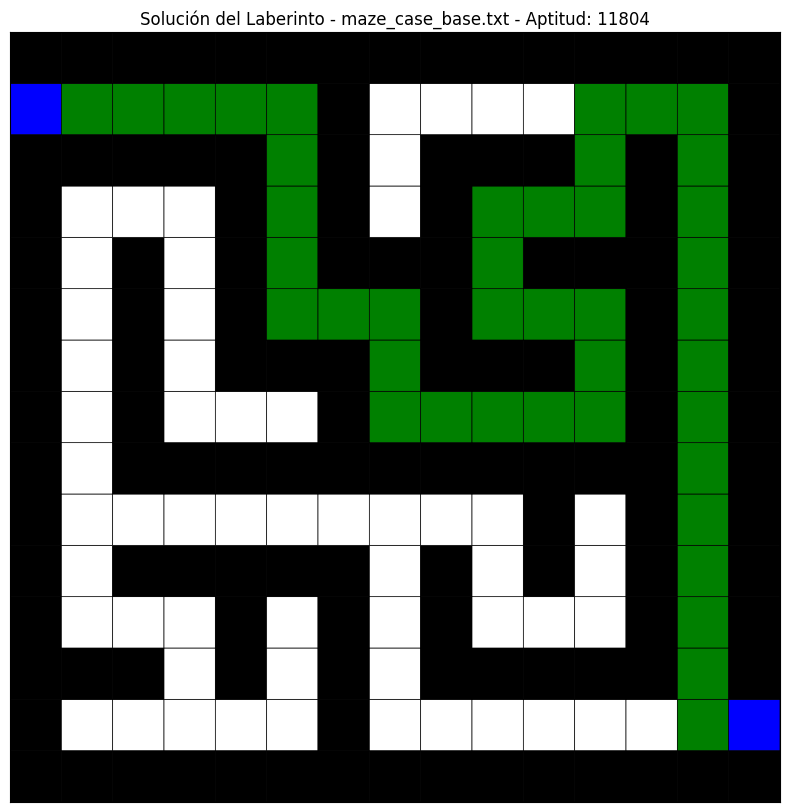

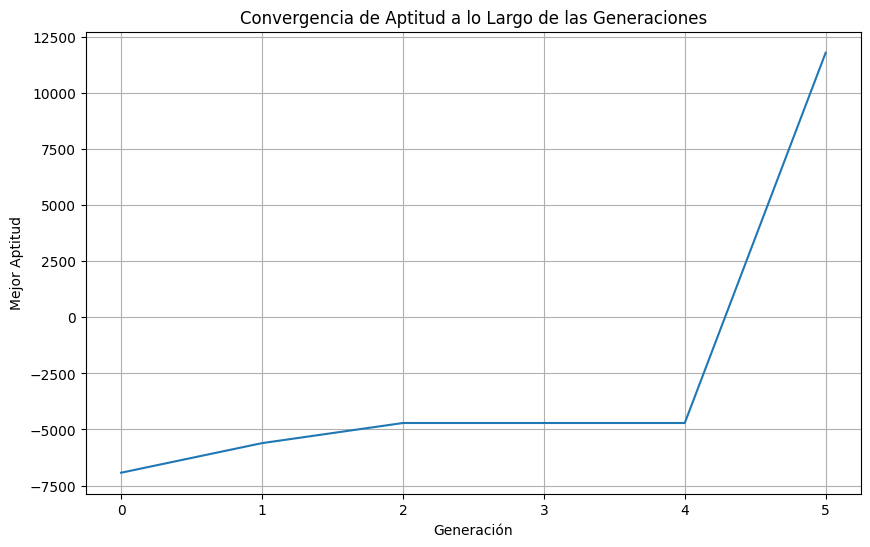

In [45]:
if __name__ == "__main__":
    # Caso base
    resolvedor_base = ejecutar_experimento("maze_case_base.txt", 
                                        pasos_maximos=500, 
                                        tamano_poblacion=300, 
                                        generaciones=200)

Ejecución de caso heavy

Ejecutando experimento en maze_case_heavy.txt
Generación 0: Nueva mejor aptitud = -18783
Generación 0: Mejor Aptitud = -18783, Promedio = -25416.78
Generación 1: Nueva mejor aptitud = -18776
Generación 2: Nueva mejor aptitud = -18591
Generación 3: Nueva mejor aptitud = -17410
Generación 4: Nueva mejor aptitud = -17362
Generación 5: Nueva mejor aptitud = -9685
Generación 8: Nueva mejor aptitud = -9510
Generación 9: Nueva mejor aptitud = -4065
Generación 10: Nueva mejor aptitud = -2488
Generación 10: Mejor Aptitud = -2488, Promedio = -18707.68
Generación 11: Nueva mejor aptitud = 2246
Generación 19: Nueva mejor aptitud = 16070
¡Solución encontrada! Longitud del camino: 451 pasos
Solución encontrada, deteniendo algoritmo.
Mejor aptitud: 16070
Longitud del camino: 451
¿Se alcanzó la salida?: True
Tiempo transcurrido: 13.02 segundos


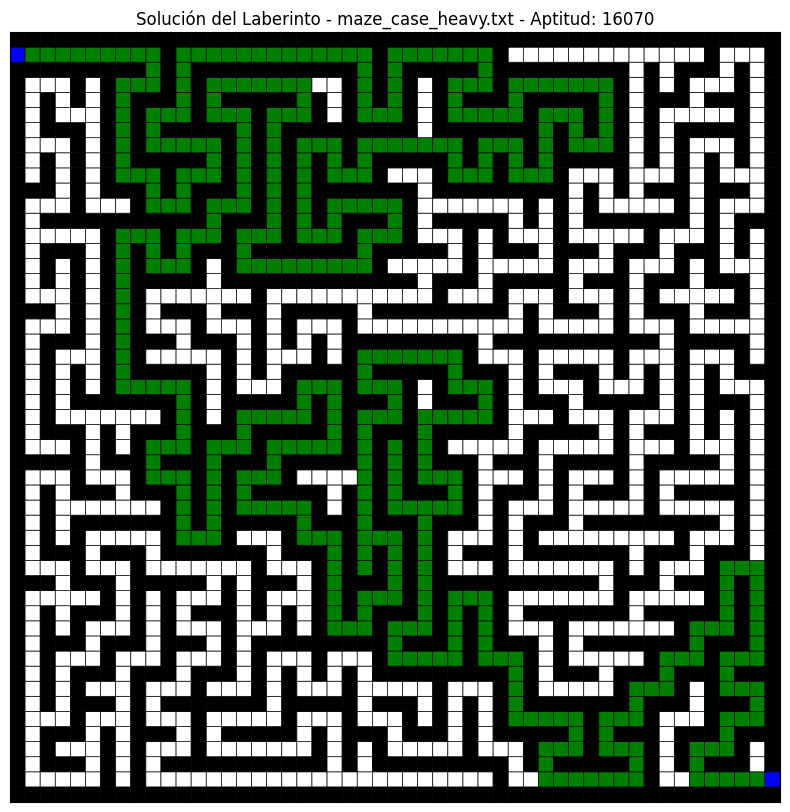

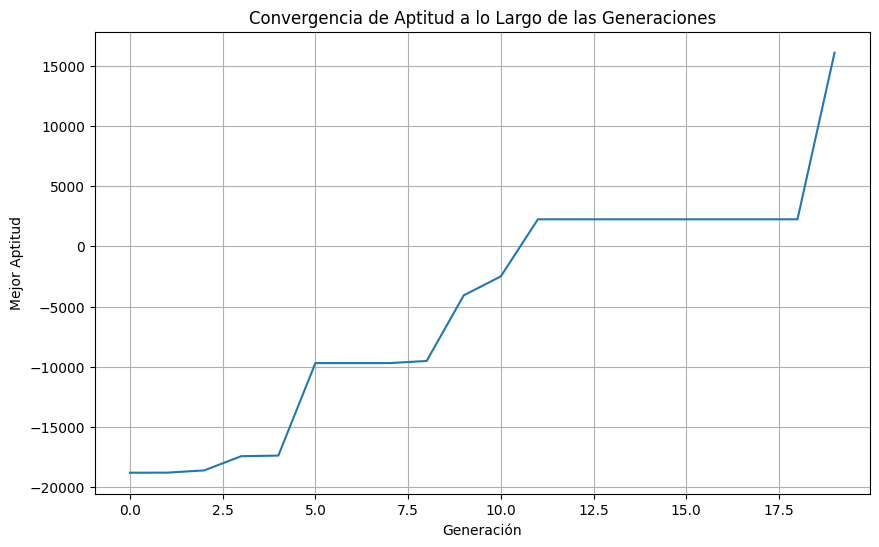

In [46]:
if __name__ == "__main__":
    # Caso pesado
    resolvedor_pesado = ejecutar_experimento("maze_case_heavy.txt", 
                                         pasos_maximos=1000, 
                                         tamano_poblacion=300, 
                                         generaciones=300)


## Problema 2: Nomad Crawler

In [ ]:
import numpy as np
from typing import Tuple, List
import random
import matplotlib.pyplot as plt

def generar_laberinto_aleatorio(size: int = 15) -> Tuple[np.ndarray, Tuple[int, int], Tuple[int, int]]:
   
    # Inicializar el laberinto con paredes
    maze = np.ones((size, size), dtype=int)
    
    # Generar entrada y salida aleatorias en los bordes
    edges = []
    for i in range(size):
        edges.extend([(0, i), (size-1, i), (i, 0), (i, size-1)])
    
    # Seleccionar entrada y salida aleatorias
    entry, exit = random.sample(edges, 2)
    maze[entry] = 0
    maze[exit] = 0
    
    
    def dfs(x: int, y: int, visited: List[Tuple[int, int]]):
        visited.append((x, y))
        maze[x, y] = 0
        
        # Direcciones posibles: arriba, derecha, abajo, izquierda
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)
        
        for dx, dy in directions:
            new_x, new_y = x + dx*2, y + dy*2
            if (0 <= new_x < size and 0 <= new_y < size and 
                (new_x, new_y) not in visited):
                # Marcar la celda intermedia como camino
                maze[x + dx, y + dy] = 0
                dfs(new_x, new_y, visited)
    
    # Comenzar DFS desde la entrada
    dfs(entry[0], entry[1], [])
    
    # Asegurar que la salida sea accesible
    if maze[exit] == 1:
        x, y = exit
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            new_x, new_y = x + dx, y + dy
            if (0 <= new_x < size and 0 <= new_y < size and 
                maze[new_x, new_y] == 0):
                maze[x, y] = 0
                break
    
    return maze, entry, exit

def generar_k_labertinos(k: int = 10, size: int = 15) -> List[Tuple[np.ndarray, Tuple[int, int], Tuple[int, int]]]:
    return [generar_laberinto_aleatorio(size) for _ in range(k)]




In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

MOVIMIENTOS = {
    0: (-1, 0),  # Norte
    1: (1, 0),   # Sur
    2: (0, 1),   # Este
    3: (0, -1),  # Oeste
}

class AlgoritmoGeneticoNomadCrawler:
    def __init__(self, k_mazes, pasos_maximos=300, tamano_poblacion=300, generaciones=300,
                 tasa_mutacion=0.3, tasa_cruce=0.7, tamano_elite=10):
        self.mazes = k_mazes
        self.pasos_maximos = pasos_maximos
        self.tamano_poblacion = tamano_poblacion
        self.generaciones = generaciones
        self.tasa_mutacion = tasa_mutacion
        self.tasa_cruce = tasa_cruce
        self.tamano_elite = tamano_elite
        self.tamano_estado = 256
        self.poblacion = []
        self.historial_aptitud = []
        self.mejor_individuo = None
        self.mejor_aptitud = -np.inf

    def detectar_estado(self, maze, pos, ultimo_mov):
        x, y = pos
        paredes = 0
        for i, (dx, dy) in enumerate(MOVIMIENTOS.values()):
            nx, ny = x + dx, y + dy
            if nx < 0 or ny < 0 or nx >= maze.shape[0] or ny >= maze.shape[1] or maze[nx, ny] == 1:
                paredes |= (1 << i)
        bits_mov = (1 << (4 + ultimo_mov)) if ultimo_mov is not None else 0
        return paredes | bits_mov

    def crear_individuo(self):
        return np.random.randint(0, 4, size=self.tamano_estado)

    def inicializar_poblacion(self):
        self.poblacion = [self.crear_individuo() for _ in range(self.tamano_poblacion)]

    def simular_en_laberinto(self, maze, entrada, salida, individuo):
        x, y = entrada
        pasos = 0
        ultimo_mov = None
        for _ in range(self.pasos_maximos):
            if (x, y) == salida:
                return True, pasos
            estado = self.detectar_estado(maze, (x, y), ultimo_mov)
            accion = individuo[estado]
            dx, dy = MOVIMIENTOS[accion]
            nx, ny = x + dx, y + dy
            if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1] and maze[nx, ny] == 0:
                x, y = nx, ny
            ultimo_mov = accion
            pasos += 1
        return False, pasos

    def evaluar_individuo(self, individuo):
        exitos = 0
        pasos_totales = 0
        penalizaciones_totales = 0

        for maze, entrada, salida in self.mazes:
            x, y = entrada
            pasos = 0
            penalizaciones = 0
            ultimo_mov = None

            for _ in range(self.pasos_maximos):
                if (x, y) == salida:
                    exitos += 1
                    break

                estado = self.detectar_estado(maze, (x, y), ultimo_mov)
                accion = individuo[estado]
                dx, dy = MOVIMIENTOS[accion]
                nx, ny = x + dx, y + dy

                if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1] and maze[nx, ny] == 0:
                    x, y = nx, ny
                else:
                    penalizaciones += 1  # intento de movimiento inválido

                ultimo_mov = accion
                pasos += 1

            pasos_totales += pasos
            penalizaciones_totales += penalizaciones

        tasa_exito = exitos / len(self.mazes)
        prom_pasos = pasos_totales / len(self.mazes)
        prom_penalizaciones = penalizaciones_totales / len(self.mazes)

        # Fórmula balanceada de aptitud, revisar con pruebas 
        fitness = (
            1000 * tasa_exito                  
            - prom_pasos                      
            - 2 * prom_penalizaciones         
        )
        return fitness



    def seleccionar_padres(self, aptitudes):
        indices = []
        for _ in range(self.tamano_poblacion):
            torneo = random.sample(range(self.tamano_poblacion), 3)
            ganador = max(torneo, key=lambda i: aptitudes[i])
            indices.append(ganador)
        return indices

    def cruzar(self, p1, p2):
        if random.random() > self.tasa_cruce:
            return np.copy(p1)
        hijo = np.copy(p1)
        for i in range(self.tamano_estado):
            if random.random() < 0.5:
                hijo[i] = p2[i]
        return hijo

    def mutar(self, individuo):
        for i in range(self.tamano_estado):
            if random.random() < self.tasa_mutacion:
                individuo[i] = random.randint(0, 3)
        return individuo

    def evolucionar(self):
        self.inicializar_poblacion()
        for gen in range(self.generaciones):
            aptitudes = [self.evaluar_individuo(ind) for ind in self.poblacion]
            self.historial_aptitud.append(max(aptitudes))
            elite_idx = np.argsort(aptitudes)[-self.tamano_elite:]
            elite = [self.poblacion[i] for i in elite_idx]

            if max(aptitudes) > self.mejor_aptitud:
                self.mejor_aptitud = max(aptitudes)
                self.mejor_individuo = self.poblacion[np.argmax(aptitudes)]
                print(f"Gen {gen}: Mejor aptitud = {self.mejor_aptitud:.2f}")

            padres_idx = self.seleccionar_padres(aptitudes)
            nueva_pob = elite[:]
            while len(nueva_pob) < self.tamano_poblacion:
                p1 = self.poblacion[random.choice(padres_idx)]
                p2 = self.poblacion[random.choice(padres_idx)]
                hijo = self.mutar(self.cruzar(p1, p2))
                nueva_pob.append(hijo)
            self.poblacion = nueva_pob
        return self.mejor_individuo

    def graficar_convergencia(self):
        plt.plot(self.historial_aptitud)
        plt.title("Convergencia del algoritmo")
        plt.xlabel("Generación")
        plt.ylabel("Mejor aptitud")
        plt.grid(True)
        plt.show()



Gen 0: Mejor aptitud = -479.80
Gen 1: Mejor aptitud = -352.00
Gen 3: Mejor aptitud = -341.00
Gen 5: Mejor aptitud = -340.60
Gen 7: Mejor aptitud = -300.40
Gen 23: Mejor aptitud = -300.00
Gen 64: Mejor aptitud = -269.70
Gen 72: Mejor aptitud = -226.50
Gen 87: Mejor aptitud = -225.70
Gen 88: Mejor aptitud = -162.40
Gen 100: Mejor aptitud = -104.10
Gen 104: Mejor aptitud = -43.20
Gen 107: Mejor aptitud = -40.10
Gen 110: Mejor aptitud = -27.30
Gen 121: Mejor aptitud = 76.40
Gen 150: Mejor aptitud = 79.70
Gen 167: Mejor aptitud = 92.70
Gen 177: Mejor aptitud = 99.30
Gen 189: Mejor aptitud = 145.80
Gen 215: Mejor aptitud = 197.00
Gen 288: Mejor aptitud = 211.70


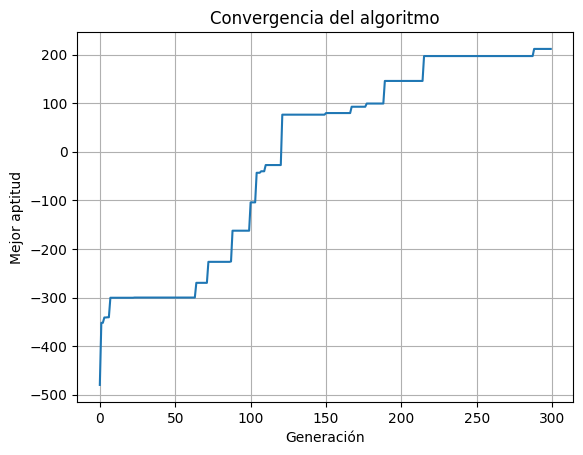

In [ ]:
mazes = generar_k_labertinos(k=10)

ag = AlgoritmoGeneticoNomadCrawler(mazes)
mejor_individuo = ag.evolucionar()

# grafica convergencia
ag.graficar_convergencia()



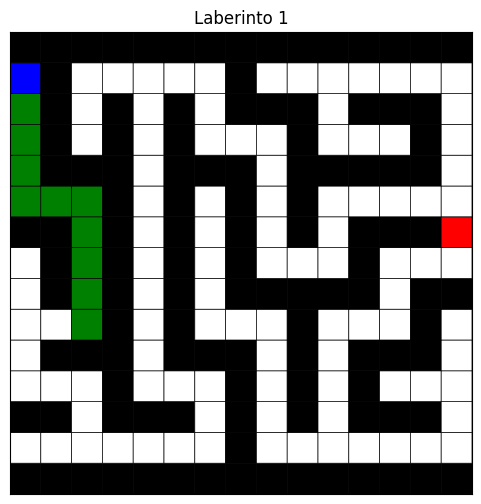

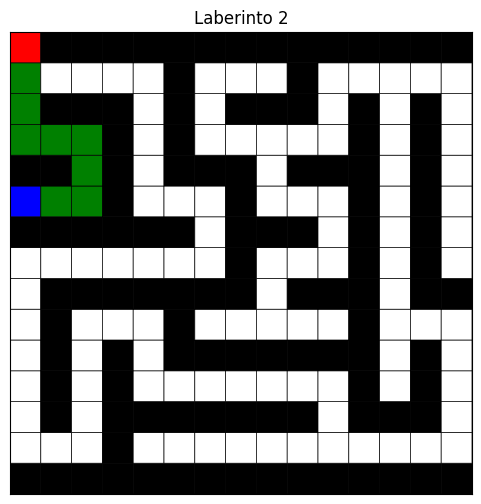

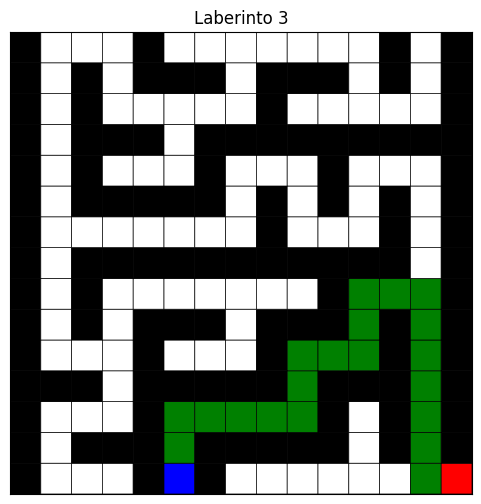

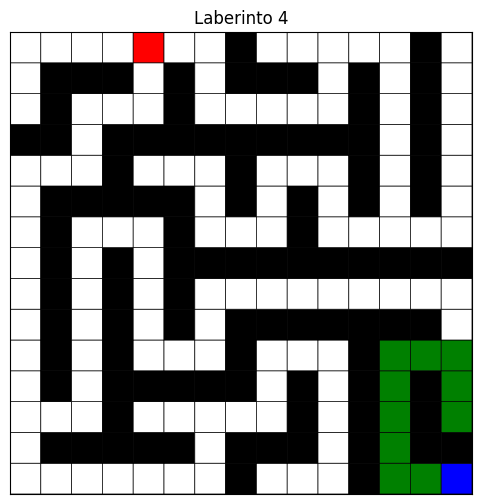

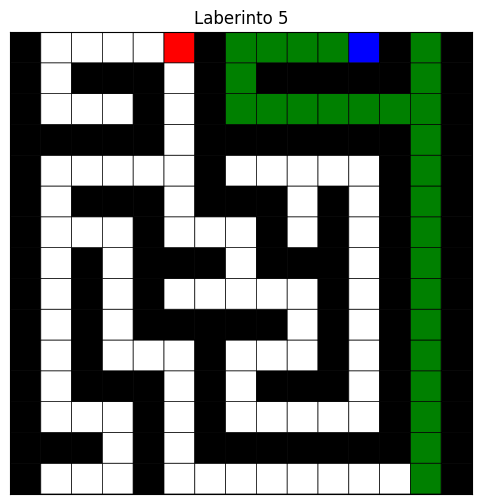

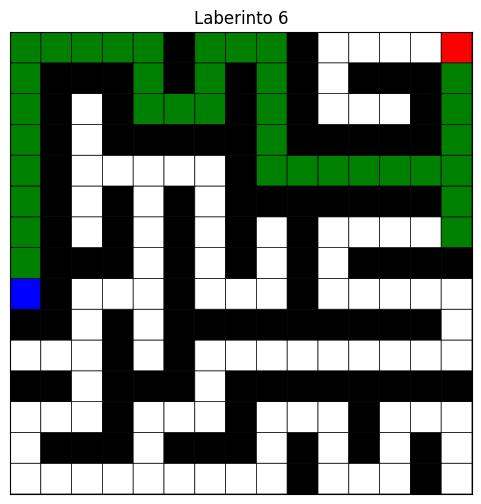

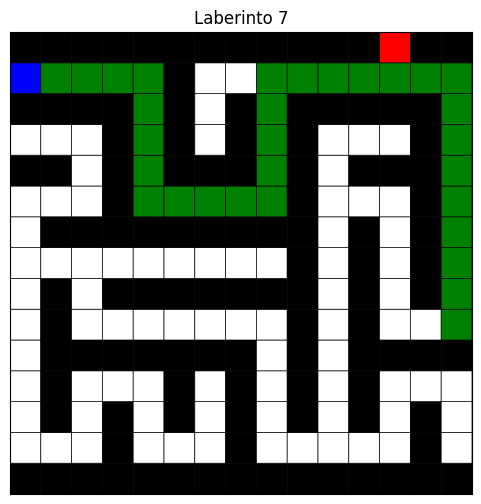

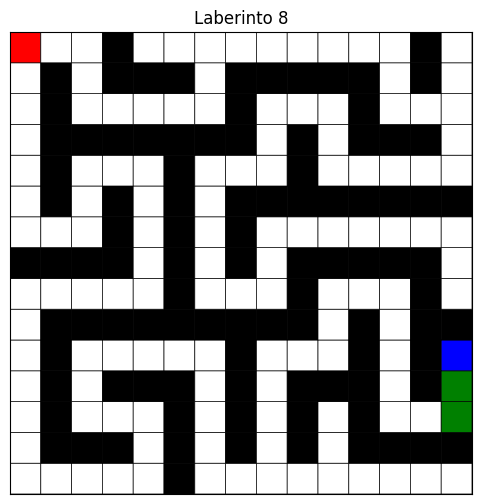

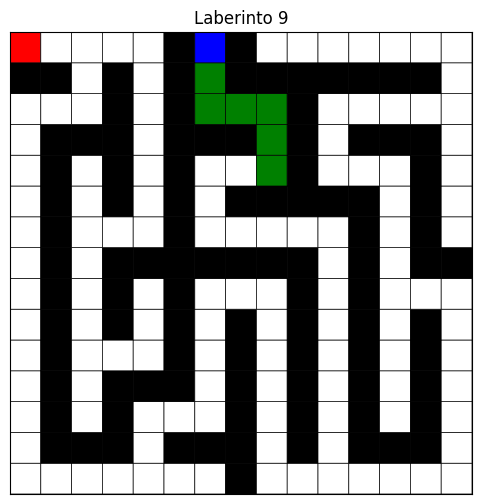

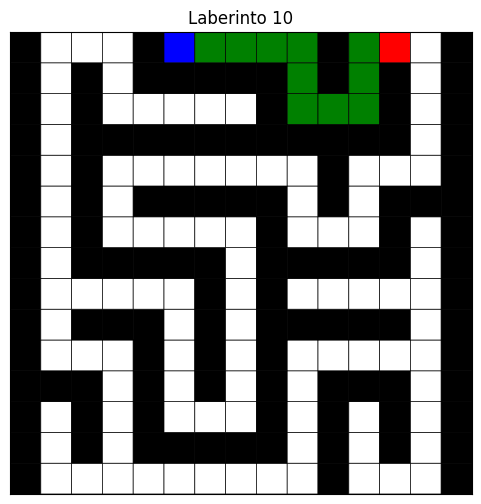

In [63]:
def mostrar_camino_en_laberinto(maze, entrada, salida, individuo, pasos_maximos=300, titulo="Camino recorrido"):
    from matplotlib.colors import ListedColormap

    x, y = entrada
    camino = [(x, y)]
    ultimo_mov = None

    for _ in range(pasos_maximos):
        if (x, y) == salida:
            break
        estado = ag.detectar_estado(maze, (x, y), ultimo_mov)
        accion = individuo[estado]
        dx, dy = MOVIMIENTOS[accion]
        nx, ny = x + dx, y + dy
        if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1] and maze[nx, ny] == 0:
            x, y = nx, ny
        ultimo_mov = accion
        camino.append((x, y))

    # Crear copia del laberinto para visualización
    visual = np.copy(maze)
    for px, py in camino:
        visual[px, py] = 2  # camino
    visual[entrada] = 3
    visual[salida] = 4

    cmap = ListedColormap(['white', 'black', 'green', 'blue', 'red'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(visual[::-1], cmap=cmap, edgecolors='k', linewidths=0.5)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title(titulo)
    plt.show()
    
for i, (maze, entrada, salida) in enumerate(mazes):
    mostrar_camino_en_laberinto(maze, entrada, salida, ag.mejor_individuo, titulo=f"Laberinto {i+1}")


In [64]:
def resumen_rendimiento(individuo, mazes, pasos_maximos=300):
    exitos = 0
    pasos_total = 0
    for i, (maze, entrada, salida) in enumerate(mazes):
        x, y = entrada
        pasos = 0
        ultimo_mov = None
        for _ in range(pasos_maximos):
            if (x, y) == salida:
                exitos += 1
                break
            estado = ag.detectar_estado(maze, (x, y), ultimo_mov)
            accion = individuo[estado]
            dx, dy = MOVIMIENTOS[accion]
            nx, ny = x + dx, y + dy
            if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1] and maze[nx, ny] == 0:
                x, y = nx, ny
            ultimo_mov = accion
            pasos += 1
        pasos_total += pasos
    print(f"Laberintos resueltos: {exitos}/{len(mazes)}")
    print(f" Promedio de pasos: {pasos_total / len(mazes):.2f}")
resumen_rendimiento(ag.mejor_individuo, mazes)


Laberintos resueltos: 5/10
 Promedio de pasos: 165.30


In [66]:
def evaluar_estadisticas_individuo(individuo, mazes, pasos_maximos=1000):
    tiempos = []
    exitos = 0

    for maze, entrada, salida in mazes:
        x, y = entrada
        pasos = 0
        ultimo_mov = None

        for _ in range(pasos_maximos):
            if (x, y) == salida:
                exitos += 1
                break
            estado = ag.detectar_estado(maze, (x, y), ultimo_mov)
            accion = individuo[estado]
            dx, dy = MOVIMIENTOS[accion]
            nx, ny = x + dx, y + dy

            if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1] and maze[nx, ny] == 0:
                x, y = nx, ny
            ultimo_mov = accion
            pasos += 1

        tiempos.append(pasos)

    tasa_exito = exitos / len(mazes)
    tiempo_promedio = np.mean(tiempos)
    desviacion_tiempos = np.std(tiempos)

    print(f"Tasa de éxito: {tasa_exito:.2f}")
    print(f"Pasos promedio por laberitno : {tiempo_promedio:.2f} pasos")
    print(f"Desviación estándar: {desviacion_tiempos:.2f} pasos")

    return {
        "tasa_exito": tasa_exito,
        "tiempo_promedio": tiempo_promedio,
        "desviacion": desviacion_tiempos,
        "tiempos": tiempos
    }
estadisticas = evaluar_estadisticas_individuo(ag.mejor_individuo, mazes)


Tasa de éxito: 0.50
Pasos promedio por laberitno : 515.30 pasos
Desviación estándar: 484.87 pasos


Cuando se corre el programa con la restriccion de 300 pasos maximo por laberinto el programa muchas veces no logra encontrar una solucion correcta. Vemos en los resultados mostrados anteriormente que resuelve aporximadamente el 50% de los casos. Ademas, vemos como el promedio de pasos es de 515 y la desviacion estandar de 484.87, lo que nos muestra una ejecucion un poco inestable. En unos laberintos se resuelve rapidamente mientras que en otro se agora el limite sin exito. Hicimos una simulacion subiendo el numero de pasos a 1000 y mejoran los resultados pero igual no garantiza encontrar el camino correcto con exito. 